In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from copy import deepcopy
from hydra import compose, initialize
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import MDS
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
import sys
from tqdm.auto import tqdm

sys.path.append('../..')
from data_utils import get_dsa_results, get_dsa_run_list, get_grid_search_results, get_grid_search_run_list, get_grid_search_window_ts, load_session_data, load_window_from_chunks

In [3]:
with initialize(version_base="1.3", config_path="../../DSA_comparisons/conf"):
    cfg = compose(config_name="config")

In [4]:
# data_class = cfg.params.data_class
session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, cfg.params.data_class)) if f.endswith('.mat')]

session_list = [session_list[1], session_list[2]]
# session_list = [session_list[2]]

In [5]:
session_list

['MrJones-Anesthesia-20160210-01', 'Mary-Anesthesia-20160818-02']

In [6]:
cfg.params.grid_set

'grid_set1'

# Section Definitions

In [8]:
areas = ['all']

## PCA

In [9]:
pca_chosen = {}
for session in session_list:
    print("-"*20)
    print(f"SESSION = {session}")
    print("-"*20)

    normed_folder = 'NOT_NORMED' if not cfg.params.normed else 'NORMED'
    filter_folder = f"[{cfg.params.high_pass},{cfg.params.low_pass}]" if cfg.params.low_pass is not None or cfg.params.high_pass is not None else 'NO_FILTER'

    pca_dir = os.path.join(cfg.params.grid_search_results_dir, cfg.params.data_class, "PCA_info", session, normed_folder, f"SUBSAMPLE_{cfg.params.subsample}", filter_folder, f"WINDOW_{cfg.params.window}")
    os.makedirs(pca_dir, exist_ok=True)

    pca_chosen[session] = {}
    for area in areas:

        # Get the relevant indices for each area
        os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
        variables = ['electrodeInfo']
        session_vars, T, N, dt = load_session_data(session, cfg.params.all_data_dir, variables, data_class=cfg.params.data_class, verbose=False)
        electrode_info = session_vars['electrodeInfo']

        if area == 'all':
            dimension_inds = np.arange(len(electrode_info['area']))
        else:
            dimension_inds = np.where(electrode_info['area'] == area)[0]

        # Get PCA explained variance ratios
        area_pca_file = os.path.join(pca_dir, area)
        if os.path.exists(area_pca_file):
            print(f"Found PCA info for {session}: {area}")
            pca_explained_variance_ratios = pd.read_pickle(area_pca_file)
        else:
            print(f"Computing PCA info for {session}: {area}")
            grid_search_window_start_ts = get_grid_search_window_ts(session, cfg.params.all_data_dir, cfg.params.data_class, section_info, cfg.params.num_windows_per_section, window_radius=30, random_state=cfg.params.random_state)

            directory = pd.read_pickle(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, f"{session}_lfp_chunked_20s", "directory"))
        
            pca_explained_variance_ratios = {}
            for t in tqdm(grid_search_window_start_ts, desc=f'Doing PCA for {session}: {area}'):
                lfp = load_window_from_chunks(t, t + cfg.params.window, directory=directory, dimension_inds=dimension_inds)
                lfp = lfp[::cfg.params.subsample]
                # filter
                pca = PCA(n_components=lfp.shape[1]).fit(lfp)
                pca_explained_variance_ratios[t] = pca.explained_variance_ratio_

            pd.to_pickle(pca_explained_variance_ratios, area_pca_file)

        # pick the max number of PCs across windows greater than the threshold
        pca_chosen[session][area] = np.max([np.argmax(np.cumsum(evr) >= cfg.params.pca_thresh) for evr in pca_explained_variance_ratios.values()])

--------------------
SESSION = MrJones-Anesthesia-20160210-01
--------------------
Found PCA info for MrJones-Anesthesia-20160210-01: all
--------------------
SESSION = Mary-Anesthesia-20160818-02
--------------------
Found PCA info for Mary-Anesthesia-20160818-02: all


# Collect Indices to Run

In [13]:
all_indices_to_run = {}
for session in session_list:
    print("-"*20)
    print(f"SESSION = {session}")
    print("-"*20)
    grid_search_window_start_ts = get_grid_search_window_ts(session, cfg.params.all_data_dir, cfg.params.data_class, section_info, cfg.params.num_windows_per_section, window_radius=30, random_state=cfg.params.random_state)
    normed_folder = 'NOT_NORMED' if not cfg.params.normed else 'NORMED'
    filter_folder = f"[{cfg.params.high_pass},{cfg.params.low_pass}]" if cfg.params.low_pass is not None or cfg.params.high_pass is not None else 'NO_FILTER'

    grid_search_run_list = get_grid_search_run_list(session, os.path.join(cfg.params.grid_search_results_dir, cfg.params.data_class), cfg.params.all_data_dir, cfg.params.window, cfg.grid_sets[cfg.params.grid_set], cfg.params.grid_set, grid_search_window_start_ts, cfg.params.T_pred, group_ranks=cfg.params.group_ranks, verbose=True, random_state=cfg.params.random_state)

    for area in areas:
        
        pca_folder = "NO_PCA" if not cfg.params.pca else f"PCA_{pca_chosen[session][area]}"
        save_dir = os.path.join(cfg.params.grid_search_results_dir, cfg.params.data_class, 'grid_search_results', session, normed_folder, f"SUBSAMPLE_{cfg.params.subsample}", filter_folder, f"WINDOW_{cfg.params.window}", cfg.params.grid_set, area, pca_folder)

        os.makedirs(save_dir, exist_ok=True)
        
        saved_files = os.listdir(save_dir)

        
        if not cfg.params.group_ranks:
            # filter runs for those with valid rank
            filtered_run_list = []
            for run_index, run_info in enumerate(grid_search_run_list[area]):
                if cfg.params.pca:
                    n_dims = pca_chosen[session][area]
                else:
                    n_dims = len(run_info['dimension_inds'])
                    if run_info['n_delays']*n_dims >= run_info['rank']:
                        run_info['run_index'] = run_index
                        filtered_run_list.append(run_info)
        else: # runs don't need to be filtered
            filtered_run_list = []
            for run_index, run_info in enumerate(grid_search_run_list[area]):
                run_info['run_index'] = run_index
                filtered_run_list.append(run_info)
        
        indices_to_run = []
        for run_info in filtered_run_list:
            filename = f"run_index-{run_info['run_index']}.pkl"
            if filename not in saved_files:
                indices_to_run.append(run_info['run_index'])
    
        if len(indices_to_run) == 0:
            print(f"*COMPLETE*: All results completed for {session} - {area}!!")
        elif len(indices_to_run) == len(filtered_run_list):
            print(f"NOT STARTED: no results completed for {session} - {area}. Adding all indices! ({len(indices_to_run)})")
            if session not in all_indices_to_run:
                all_indices_to_run[session] = {}
            all_indices_to_run[session][area] = indices_to_run
        else:
            print(f"INCOMPLETE: {session} - {area} incomplete, adding indices {indices_to_run}")
            if session not in all_indices_to_run:
                all_indices_to_run[session] = {}
            all_indices_to_run[session][area] = indices_to_run

--------------------
SESSION = MrJones-Anesthesia-20160210-01
--------------------
*COMPLETE*: All results completed for MrJones-Anesthesia-20160210-01 - all!!
--------------------
SESSION = Mary-Anesthesia-20160818-02
--------------------
*COMPLETE*: All results completed for Mary-Anesthesia-20160818-02 - all!!


# Running

In [11]:
os.chdir('/om2/user/eisenaj/code/UniversalUnconsciousness')
batch_size = 250

In [12]:
sessions_to_run = list(all_indices_to_run.keys())
# sessions_to_run = sessions_to_run[:4]

# iterator = tqdm(total=np.sum([len(all_indices_to_run[session]) for session in sessions_to_run]), desc='Hydra Multiprocessing - DSA on Neural Data')
iterator = tqdm(total=np.sum([np.sum([int(np.ceil(len(all_indices_to_run[session][area])/batch_size)) for area in all_indices_to_run[session].keys()]) for session in sessions_to_run]), desc='Hydra Multiprocessing - Grid Search on Neural Data')

for session in sessions_to_run:
    for area in all_indices_to_run[session].keys():
        print(f"Running indices for {session} - {area}")
        num_batches = int(np.ceil(len(all_indices_to_run[session][area])/batch_size))
        for batch_num in range(num_batches):
            batch_start = batch_num*batch_size
            batch_end = np.min([(batch_num + 1)*batch_size, len(all_indices_to_run[session][area])])
            print(f"running batch #{batch_num}")
            os.system(f"HYDRA_FULL_ERROR=1 python DSA_comparisons/run_grid_search.py -m ++params.session={session} ++params.area={area} ++params.pca_dims={int(pca_chosen[session][area])} ++params.run_index={','.join([str(i) for i in all_indices_to_run[session][area][batch_start:batch_end]])}")
            iterator.update()
iterator.close()

Hydra Multiprocessing - Grid Search on Neural Data:   0%|          | 0/1 [00:00<?, ?it/s]

Running indices for MrJones-Anesthesia-20160210-01 - all
running batch #0
[2024-07-09 12:07:12,873][HYDRA] Submitit 'slurm' sweep output dir : multirun/2024-07-09/12-07-12
[2024-07-09 12:07:12,874][HYDRA] 	#0 : ++params.session=MrJones-Anesthesia-20160210-01 ++params.area=all ++params.pca_dims=44 ++params.run_index=17
[2024-07-09 12:07:12,878][HYDRA] 	#1 : ++params.session=MrJones-Anesthesia-20160210-01 ++params.area=all ++params.pca_dims=44 ++params.run_index=20
[2024-07-09 12:07:12,881][HYDRA] 	#2 : ++params.session=MrJones-Anesthesia-20160210-01 ++params.area=all ++params.pca_dims=44 ++params.run_index=25
[2024-07-09 12:07:12,884][HYDRA] 	#3 : ++params.session=MrJones-Anesthesia-20160210-01 ++params.area=all ++params.pca_dims=44 ++params.run_index=30
[2024-07-09 12:07:12,887][HYDRA] 	#4 : ++params.session=MrJones-Anesthesia-20160210-01 ++params.area=all ++params.pca_dims=44 ++params.run_index=31
[2024-07-09 12:07:12,890][HYDRA] 	#5 : ++params.session=MrJones-Anesthesia-20160210-01 +

# Collect Grid Search Results

In [14]:
grid_search_results = get_grid_search_results(cfg, session_list, areas, len(section_info), pca_chosen)

In [15]:
session = session_list[0]
area = 'all'

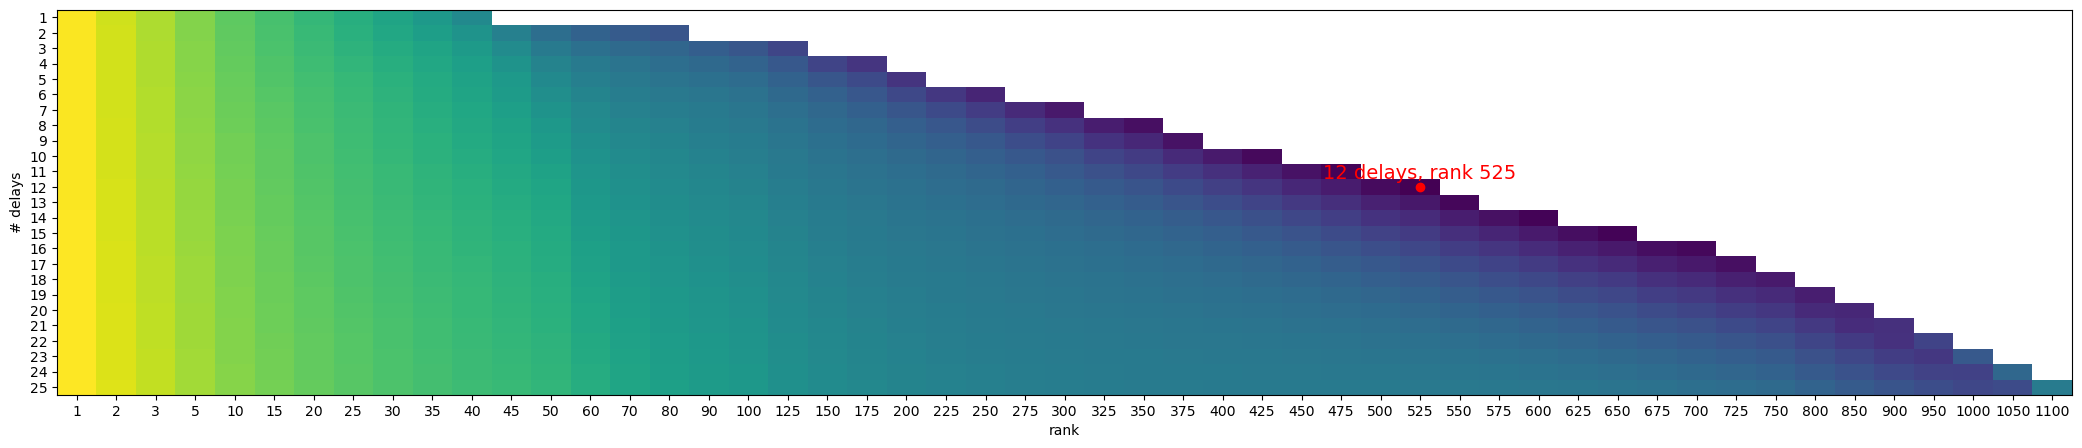

In [17]:
plt.figure(figsize=(26, 5))



n_ranks = np.argmax(np.isnan(grid_search_results[session][area]['mats'][cfg.params.stat_to_use][0, -1]))
results_to_show = deepcopy(grid_search_results[session][area]['mats'][cfg.params.stat_to_use][:, :, :n_ranks])
# results_to_show[results_to_show == 0] = np.nan

plt.imshow(results_to_show.mean(axis=0), aspect='auto')
i, j = grid_search_results[session][area]['i'], grid_search_results[session][area]['j']
plt.scatter(j, i, c='r')
n_delays = grid_search_results[session][area]['n_delays']
rank = grid_search_results[session][area]['rank']
plt.text(j, i - 0.5, f"{n_delays} delays, rank {rank}", c='r', ha='center', fontsize=14)
plt.xticks(np.arange(len(cfg.grid_sets[cfg.params.grid_set].rank_vals))[:n_ranks], cfg.grid_sets[cfg.params.grid_set].rank_vals[:n_ranks])
plt.yticks(np.arange(len(cfg.grid_sets[cfg.params.grid_set].n_delays_vals)), cfg.grid_sets[cfg.params.grid_set].n_delays_vals)
plt.ylabel('# delays')
plt.xlabel('rank')
plt.show()

# Get DSA Run List

In [27]:
all_indices_to_run = {}
for session in session_list:
    print("-"*20)
    print(f"SESSION = {session}")
    print("-"*20)
    dsa_run_list = get_dsa_run_list(cfg, session)

    normed_folder = 'NOT_NORMED' if not cfg.params.normed else 'NORMED'
    filter_folder = f"[{cfg.params.high_pass},{cfg.params.low_pass}]" if cfg.params.low_pass is not None or cfg.params.high_pass is not None else 'NO_FILTER'
    
    for area in areas:
        pca_folder = "NO_PCA" if not cfg.params.pca else f"PCA_{pca_chosen[session][area]}"
        save_dir = os.path.join(cfg.params.dsa_results_dir, cfg.params.data_class, 'dsa_results', session, normed_folder, f"SUBSAMPLE_{cfg.params.subsample}", filter_folder, f"WINDOW_{cfg.params.window}", cfg.params.grid_set, f"STAT_TO_USE_{cfg.params.stat_to_use}", f"STRIDE_{cfg.params.stride}", area, pca_folder)

        os.makedirs(save_dir, exist_ok=True)
        
        saved_files = os.listdir(save_dir)
        indices_to_run = []
        for run_index in range(len(dsa_run_list[area])):
            filename = f"run_index-{run_index}.pkl"
            if filename not in saved_files:
                indices_to_run.append(run_index)
        
        if len(indices_to_run) == 0:
            print(f"*COMPLETE*: All results completed for {session} - {area}!!")
        elif len(indices_to_run) == len(dsa_run_list[area]):
            print(f"NOT STARTED: no results completed for {session} - {area}. Adding all indices! ({len(indices_to_run)})")
            if session not in all_indices_to_run:
                all_indices_to_run[session] = {}
            all_indices_to_run[session][area] = indices_to_run
        else:
            print(f"INCOMPLETE: {session} - {area} incomplete, adding indices {indices_to_run}")
            if session not in all_indices_to_run:
                all_indices_to_run[session] = {}
            all_indices_to_run[session][area] = indices_to_run

--------------------
SESSION = MrJones-Anesthesia-20160210-01
--------------------
*COMPLETE*: All results completed for MrJones-Anesthesia-20160210-01 - all!!
--------------------
SESSION = Mary-Anesthesia-20160818-02
--------------------
*COMPLETE*: All results completed for Mary-Anesthesia-20160818-02 - all!!


### Run

In [28]:
os.chdir('/om2/user/eisenaj/code/UniversalUnconsciousness')
batch_size = 250

In [29]:
sessions_to_run = list(all_indices_to_run.keys())
# sessions_to_run = sessions_to_run[:4]

# iterator = tqdm(total=np.sum([len(all_indices_to_run[session]) for session in sessions_to_run]), desc='Hydra Multiprocessing - DSA on Neural Data')
iterator = tqdm(total=np.sum([np.sum([int(np.ceil(len(all_indices_to_run[session][area])/batch_size)) for area in all_indices_to_run[session].keys()]) for session in sessions_to_run]), desc='Hydra Multiprocessing - Grid Search on Neural Data')

for session in sessions_to_run:
    for area in all_indices_to_run[session].keys():
        print(f"Running indices for {session} - {area}")
        num_batches = int(np.ceil(len(all_indices_to_run[session][area])/batch_size))
        for batch_num in range(num_batches):
            batch_start = batch_num*batch_size
            batch_end = np.min([(batch_num + 1)*batch_size, len(all_indices_to_run[session][area])])
            print(f"running batch #{batch_num}")
            os.system(f"HYDRA_FULL_ERROR=1 python DSA_comparisons/run_dsa.py -m ++params.session={session} ++params.area={area} ++params.pca_dims={int(pca_chosen[session][area])} ++params.n_delays={int(grid_search_results[session][area]['n_delays'])} ++params.rank={int(grid_search_results[session][area]['rank'])} ++params.run_index={','.join([str(i) for i in all_indices_to_run[session][area][batch_start:batch_end]])}")
            iterator.update()
iterator.close()

Hydra Multiprocessing - Grid Search on Neural Data: 0it [00:00, ?it/s]

# Collect DSA Results

In [30]:
dsa_results = get_dsa_results(cfg, session_list, areas, pca_chosen)

In [31]:
session = session_list[0]

In [32]:
variables = ['sessionInfo']
session_vars, T, N, dt = load_session_data(session, cfg.params.all_data_dir, variables, data_class=cfg.params.data_class, verbose=False)
session_info = session_vars['sessionInfo']

In [33]:
dsa_run_list = get_dsa_run_list(cfg, session)

In [34]:
for area in areas:
    break

In [35]:
min_time = -15
max_time = 75

# time_vals = np.arange(n)*cfg.params.stride/60 - session_info['drugStart'][0]/60
min_t = np.min([run_info['window1_start'] for run_info in dsa_run_list[area]])
max_t = np.max([run_info['window2_start'] for run_info in dsa_run_list[area]])
time_vals = np.arange(min_t, max_t + cfg.params.stride/2, cfg.params.stride)/60 - session_info['drugStart'][0]/60
dissimilarity_mat = deepcopy(dsa_results[session][area])
# ind_offset = np.argmax((time_vals >= min_time) & (time_vals <= max_time))
ind_offset = 0
dissimilarity_mat = dissimilarity_mat[(time_vals >= min_time) & (time_vals <= max_time)]
dissimilarity_mat = dissimilarity_mat[:, (time_vals >= min_time) & (time_vals <= max_time)]
time_vals = time_vals[(time_vals >= min_time) & (time_vals <= max_time)]
log_dissimilarity_mat = deepcopy(dissimilarity_mat)
log_dissimilarity_mat[dissimilarity_mat > 0] = np.log(dissimilarity_mat[dissimilarity_mat > 0])
min_val = log_dissimilarity_mat[dissimilarity_mat > 0].min()
log_dissimilarity_mat[dissimilarity_mat == 0] = min_val

In [36]:
def convert_to_ind(t, stride):
    # print(t)
    # return int(np.round(t/stride))
    return np.intp(np.round((t - time_vals[0])*60/stride))

stride = cfg.params.stride

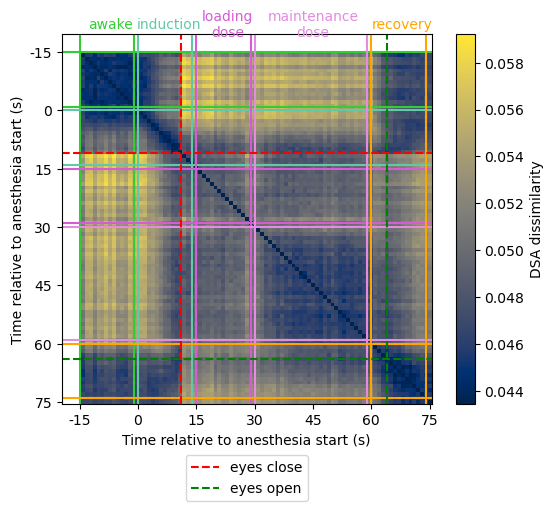

In [39]:
log = False

if log:
    min_val = log_dissimilarity_mat[dissimilarity_mat > 0].min()
    max_val = log_dissimilarity_mat[dissimilarity_mat > 0].max()
    norm = Normalize(vmin=min_val, vmax=max_val)
    plt.imshow(log_dissimilarity_mat, norm=norm, cmap='cividis')
    plt.colorbar(label='log dissimilarity')
else:
    min_val = dissimilarity_mat[dissimilarity_mat > 0].min()
    max_val = dissimilarity_mat[dissimilarity_mat > 0].max()
    norm = Normalize(vmin=min_val, vmax=max_val)
    plt.imshow(dissimilarity_mat, norm=norm, cmap='cividis')
    plt.colorbar(label='DSA dissimilarity')

# xticks = plt.xticks()[0]
# xlim = plt.xlim()
# xticks = xticks[(xticks >= xlim[0]) & (xticks <= xlim[-1])]
# xticklabels = [time_vals[int(tick)] for tick in xticks]

xticklabels = [-15, 0, 15, 30, 45, 60, 75]
xticks = [convert_to_ind(tl, stride) - ind_offset for tl in xticklabels]

plt.xticks(xticks, xticklabels)
plt.yticks(xticks, xticklabels)

plt.xlabel('Time relative to anesthesia start (s)')
plt.ylabel('Time relative to anesthesia start (s)')

vpos = -22.5
for section, times in section_info:
    plt.axhline(convert_to_ind(times[0], stride) - ind_offset, c=section_colors[section])
    plt.axhline(convert_to_ind(times[1], stride) - ind_offset - 1, c=section_colors[section])
    plt.axvline(convert_to_ind(times[0], stride) - ind_offset, c=section_colors[section])
    plt.axvline(convert_to_ind(times[1], stride) - ind_offset-1, c=section_colors[section])
    
    plt.text(convert_to_ind(np.mean(times), stride) - ind_offset, convert_to_ind(vpos, stride), '\n'.join(section.split(' ')), ha='center', va='center', c=section_colors[section])

if isinstance(session_info['eyesClose'], list) or isinstance(session_info['eyesClose'], np.ndarray):
    eyes_close = (session_info['eyesClose'][-1] - session_info['drugStart'][0])/60
else:
    eyes_close = (session_info['eyesClose'] - session_info['drugStart'][0])/60
if isinstance(session_info['eyesOpen'], list) or isinstance(session_info['eyesOpen'], np.ndarray):
    eyes_open = (session_info['eyesOpen'][-1] - session_info['drugStart'][0])/60
else:
    eyes_open = (session_info['eyesOpen'] - session_info['drugStart'][0])/60
plt.axhline(convert_to_ind(eyes_close, stride), c='r', linestyle='--')
plt.axvline(convert_to_ind(eyes_close, stride), c='r', linestyle='--')
plt.axhline(convert_to_ind(eyes_open, stride), c='green', linestyle='--')
plt.axvline(convert_to_ind(eyes_open, stride), c='green', linestyle='--')

ln1 = plt.plot([], [], c='r', linestyle='--', label='eyes close')
ln2 = plt.plot([], [], c='green', linestyle='--', label='eyes open')
lns = ln1 + ln2
plt.legend(lns, [ln.get_label() for ln in lns], loc='center', bbox_to_anchor=(0.5, -0.2))

plt.show()

In [50]:
convert_to_ind(time_vals[0], stride)

0

In [48]:
xticks

[-1, 14, 29, 44, 59, 74, 89]

## Logistic Regression

In [41]:
if isinstance(session_info['eyesClose'], list) or isinstance(session_info['eyesClose'], np.ndarray):
    eyes_close = (session_info['eyesClose'][-1] - session_info['drugStart'][0])/60
else:
    eyes_close = (session_info['eyesClose'] - session_info['drugStart'][0])/60
if isinstance(session_info['eyesOpen'], list) or isinstance(session_info['eyesOpen'], np.ndarray):
    eyes_open = (session_info['eyesOpen'][-1] - session_info['drugStart'][0])/60
else:
    eyes_open = (session_info['eyesOpen'] - session_info['drugStart'][0])/60

In [42]:
labels = (time_vals >= eyes_close) & (time_vals <= eyes_open)

In [43]:
# Initialize the logistic regression model
model = LogisticRegression(max_iter=2000, penalty='l2')

# Initialize the stratified k-fold cross-validator
kf = StratifiedKFold(n_splits=4)

X = dissimilarity_mat
# X = np.random.randn(*dissimilarity_mat.shape)
y = labels

auroc_scores = []

# Perform cross-validation
ind = 0
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    auroc = roc_auc_score(y_test, y_pred_prob)
    auroc_scores.append(auroc)

    # if ind == 2:
    #     break
    # ind += 1

# Print AUROC for each fold
for fold_idx, auroc in enumerate(auroc_scores):
    print(f"Fold {fold_idx + 1}: AUROC = {auroc:.4f}")

Fold 1: AUROC = 1.0000
Fold 2: AUROC = 1.0000
Fold 3: AUROC = 1.0000
Fold 4: AUROC = 1.0000


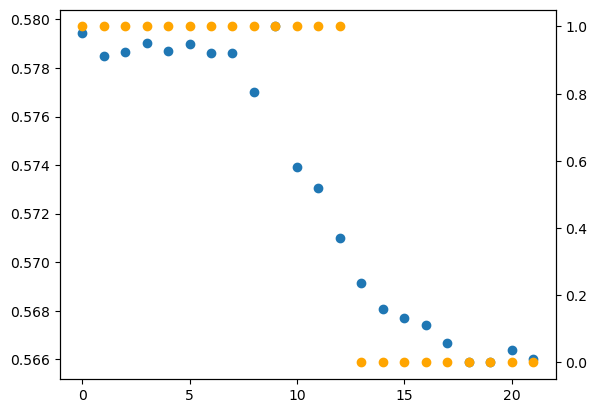

In [44]:
plt.scatter(np.arange(len(y_test)), model.predict_proba(X_test)[:, 1])
ax = plt.gca()
ax = ax.twinx()
ax.scatter(np.arange(len(y_test)), y_test, c='orange')

## MDS

In [45]:
dissim_mds = MDS(n_components=2, dissimilarity='precomputed', normalized_stress='auto').fit_transform(dissimilarity_mat)

In [46]:
colors = []
labels = []
for t in time_vals:
    if t >= eyes_close and t <= eyes_open:
        colors.append('plum')
        labels.append('unconscious')
    else:
        colors.append('limegreen')
        labels.append('awake')
    
    # for section, times in section_info:
        # if t < times[1] and t >= times[0]:
        #     colors.append(section_colors[section])
        #     labels.append(section)
        #     break
        
labels = np.array(labels)

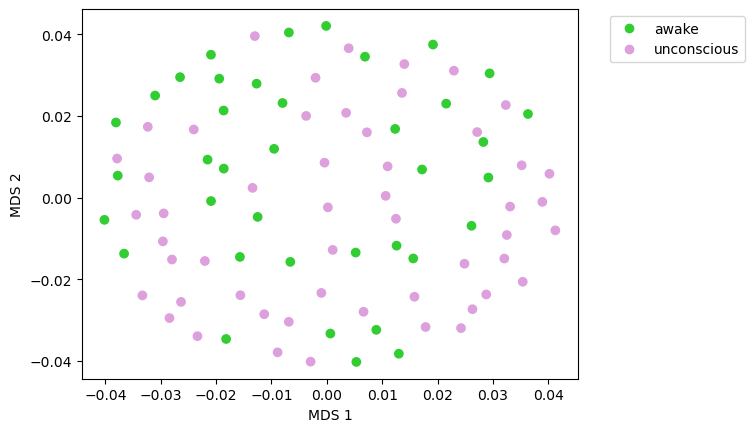

In [47]:
fig = plt.figure()
if dissim_mds.shape[-1] == 3:
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(dissim_mds[:, 0], dissim_mds[:, 1], dissim_mds[:, 2], c=colors)

    for section, times in section_info:
        ax.scatter([], [], [], c=section_colors[section], label=section)

else:
    ax = plt.gca()
    plt.scatter(dissim_mds[:, 0], dissim_mds[:, 1], c=colors)

    # for section, times in section_info:
    #     ax.scatter([], [], c=section_colors[section], label=section)

    ax.plot([], [], 'o', c='limegreen', label='awake')
    ax.plot([], [], 'o', c='plum', label='unconscious')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('MDS 1')
plt.ylabel('MDS 2')
plt.show()

In [264]:
from sklearn.metrics import silhouette_score

In [265]:
silhouette_score(dissimilarity_mat, labels, metric='precomputed')

0.1260529828110508

In [275]:
colors = []
labels = []
for t in time_vals:
    if t >= eyes_close and t < 60:
        colors.append('plum')
        labels.append('unconscious')
    elif t < eyes_close and t > 0:
        colors.append(section_colors['induction'])
        labels.append('induction')
    elif t < eyes_open and t > 60:
        colors.append(section_colors['recovery'])
        labels.append('recovery')
    else:
        colors.append('limegreen')
        labels.append('awake')
    
    # for section, times in section_info:
        # if t < times[1] and t >= times[0]:
        #     colors.append(section_colors[section])
        #     labels.append(section)
        #     break
        
labels = np.array(labels)

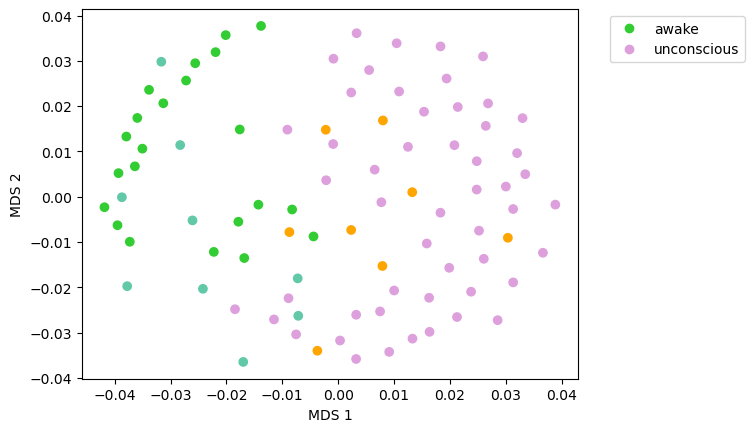

In [276]:
fig = plt.figure()
if dissim_mds.shape[-1] == 3:
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(dissim_mds[:, 0], dissim_mds[:, 1], dissim_mds[:, 2], c=colors)

    for section, times in section_info:
        ax.scatter([], [], [], c=section_colors[section], label=section)

else:
    ax = plt.gca()
    plt.scatter(dissim_mds[:, 0], dissim_mds[:, 1], c=colors)

    # for section, times in section_info:
    #     ax.scatter([], [], c=section_colors[section], label=section)

    ax.plot([], [], 'o', c='limegreen', label='awake')
    ax.plot([], [], 'o', c='plum', label='unconscious')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('MDS 1')
plt.ylabel('MDS 2')
plt.show()